### Calculate geopotential from pressure & temperature data

Calculates geopotential from pressure and temperature data for a single timestep over the entire AUS2200 domain. Can be used to provide geopotential more frequently that is output by the model. 

In [1]:
import xarray as xr
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

In [2]:
Rd = 287.1
g0 = 9.81

specific_humidity_at_level = 'fld_s00i010'
pressure_at_level = 'fld_s00i408'
temperature_at_level = 'fld_s16i004'

surface_pressure = 'fld_s00i409'
surface_temperature = 'fld_s00i024'
specific_humidity = 'fld_s03i237'

plev19=np.array([100000, 92500, 85000, 70000,
        60000, 50000, 40000, 30000,
        25000, 20000, 15000, 10000,
        7000, 5000, 3000, 2000,
        1000, 500, 100],dtype=np.float32)

def interp_and_integrate_over_pressure_with_surf(pres, var, surf_pres, surf_var, plev):

    pres_with_surf = np.insert(pres,0,surf_pres)
    var_with_surf = np.insert(var,0,surf_var)

    vint = interp1d(pres_with_surf,var_with_surf,kind="linear",fill_value="extrapolate")
    interped = vint(plev)

    all_pres = np.zeros(len(pres_with_surf)+len(plev))
    all_fld  = np.zeros(len(pres_with_surf)+len(plev))
    plev_idx = np.zeros(len(plev),dtype=int)
    surf_idx = -1
    ### Now intersperse with original var
    i = 0
    j = 0

    for _ in range(len(all_pres)):
        if j >= len(pres_with_surf):
            pres_test = -1
        else:
            pres_test = pres_with_surf[j]
        if i >= len(plev):
            plev_test = -1
        else:
            plev_test = plev[i]
        
        if plev_test > pres_test:
            if j == 0:
                all_pres[i+j] = 0
            else:
                all_pres[i+j] = plev_test
            all_fld[i+j] = interped[i]
            plev_idx[i] = i+j
            i+=1
        else:
            all_pres[i+j] = pres_test
            all_fld[i+j] = var_with_surf[j]
            if j == 0:
                surf_idx = i+j
            j+=1
    
    out_fld = np.zeros(len(plev_idx))
    for out_i,idx in enumerate(plev_idx):
        if idx < surf_idx:
            continue
        out_fld[out_i] = trapezoid(all_fld[surf_idx:idx+1],all_pres[surf_idx:idx+1]) * Rd * np.log(all_pres[idx]/all_pres[surf_idx]) / g0 / ( all_pres[surf_idx] - all_pres[idx] )
    return out_fld

def interp_and_integrate_over_pressure(pres, var, plev):

    vint = interp1d(pres,var,kind="linear",fill_value="extrapolate")
    interped = vint(plev)

    all_pres = np.zeros(len(pres)+len(plev))
    all_fld  = np.zeros(len(pres)+len(plev))
    plev_idx = np.zeros(len(plev),dtype=int)
    surf_idx = -1
    ### Now intersperse with original var
    i = 0
    j = 0

    for _ in range(len(all_pres)):
        if j >= len(pres):
            pres_test = -1
        else:
            pres_test = pres[j]
        if i >= len(plev):
            plev_test = -1
        else:
            plev_test = plev[i]
        
        if plev_test > pres_test:
            if j == 0:
                all_pres[i+j] = 0
            else:
                all_pres[i+j] = plev_test
            all_fld[i+j] = interped[i]
            plev_idx[i] = i+j
            i+=1
        else:
            all_pres[i+j] = pres_test
            all_fld[i+j] = var[j]
            if j == 0:
                surf_idx = i+j
            j+=1
    
    out_fld = np.zeros(len(plev_idx))
    for out_i,idx in enumerate(plev_idx):
        if idx < surf_idx:
            continue
        out_fld[out_i] = trapezoid(all_fld[surf_idx:idx+1],all_pres[surf_idx:idx+1]) * Rd * np.log(all_pres[idx]/all_pres[surf_idx]) / g0 / ( all_pres[surf_idx] - all_pres[idx] )
    return out_fld
### Tv = (1 + 0.618*specific_humidity)*temperature

### delta_Z = Rd * Tv / g0 * ln(p1/p2)

In [3]:
client=Client()
client

2024-08-22 12:18:47,923 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-08-22 12:18:47,925 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-08-22 12:18:47,932 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-spr-0693.gadi.nci.org.au/59916/proxy/8787/status,
Dashboard: /node/gadi-cpu-spr-0693.gadi.nci.org.au/59916/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35999,Workers: 4
Dashboard: /node/gadi-cpu-spr-0693.gadi.nci.org.au/59916/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45301,Total threads: 1
Dashboard: /node/gadi-cpu-spr-0693.gadi.nci.org.au/59916/proxy/42307/status,Memory: 0 B
Nanny: tcp://127.0.0.1:35929,


In [4]:
#ds = xr.open_dataset("/g/data/hh5/tmp/AUS2200/flood22-continuous/atmos/umnsa_mdl_20220221T1400_1hr.nc").sel(lat=-37.81, lon_0=144.96, method='nearest').isel(time=0)
#ds = xr.open_dataset("/g/data/hh5/tmp/AUS2200/flood22-continuous/atmos/umnsa_mdl_20220221T1400_1hr.nc").sel(lat=-7, lon_0=146, method='nearest').isel(time=0)
ds = xr.open_dataset("/g/data/hh5/tmp/AUS2200/flood22-continuous/atmos/umnsa_mdl_20220221T1400_1hr.nc",chunks={"model_theta_level_number":-1,"lat":212,"lon_0":260}).isel(time=0)

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 212. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "lon_0" starting at index 260. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [5]:
#ds3 = xr.open_dataset("/g/data/hh5/tmp/AUS2200/flood22-continuous/atmos/umnsa_spec_20220221T1400_10min.nc").sel(lat=-37.81, lon=144.96, method='nearest').isel(time=5)
#ds3 = xr.open_dataset("/g/data/hh5/tmp/AUS2200/flood22-continuous/atmos/umnsa_spec_20220221T1400_10min.nc").sel(lat=-7, lon=146, method='nearest').isel(time=5)
ds3 = xr.open_dataset("/g/data/hh5/tmp/AUS2200/flood22-continuous/atmos/umnsa_spec_20220221T1400_10min.nc",chunks={"lat":212,"lon":260}).isel(time=5)

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 212. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 260. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [6]:
ds_tv = (1 + 0.618 * ds[specific_humidity_at_level])*ds[temperature_at_level]
ds_tv = ds_tv.rename({'lon_0':'lon'})
ds_tv

<xarray.DataArray (model_theta_level_number: 70, lat: 2120, lon: 2600)> Size: 2GB
dask.array<mul, shape=(70, 2120, 2600), dtype=float32, chunksize=(70, 212, 260), chunktype=numpy.ndarray>
Coordinates:
    time                      datetime64[ns] 8B 2022-02-21T15:00:00
  * lat                       (lat) float64 17kB -48.79 -48.77 ... -6.852 -6.832
  * lon                       (lon) float64 21kB 107.5 107.5 ... 159.0 159.0
  * model_theta_level_number  (model_theta_level_number) int32 280B 1 2 ... 70
    theta_level_height        (model_theta_level_number) float64 560B dask.array<chunksize=(70,), meta=np.ndarray>
    sigma_theta               (model_theta_level_number) float64 560B dask.array<chunksize=(70,), meta=np.ndarray>

In [7]:
tv_surf = (1 + 0.618 * ds3[specific_humidity]) * ds3[surface_temperature]
tv_surf

<xarray.DataArray (lat: 2120, lon: 2600)> Size: 22MB
dask.array<mul, shape=(2120, 2600), dtype=float32, chunksize=(212, 260), chunktype=numpy.ndarray>
Coordinates:
    time                      datetime64[ns] 8B 2022-02-21T15:00:00
  * lat                       (lat) float64 17kB -48.79 -48.77 ... -6.852 -6.832
  * lon                       (lon) float64 21kB 107.5 107.5 ... 159.0 159.0
    theta_level_height        float64 8B 5.0
    model_theta_level_number  int32 4B 1
    sigma_theta               float64 8B 0.9994
    height                    float64 8B 10.0
    height_0                  float64 8B 1.5

In [8]:
surf_pres = ds3[surface_pressure]
surf_pres

<xarray.DataArray 'fld_s00i409' (lat: 2120, lon: 2600)> Size: 22MB
dask.array<getitem, shape=(2120, 2600), dtype=float32, chunksize=(212, 260), chunktype=numpy.ndarray>
Coordinates:
    time                      datetime64[ns] 8B 2022-02-21T15:00:00
  * lat                       (lat) float64 17kB -48.79 -48.77 ... -6.852 -6.832
  * lon                       (lon) float64 21kB 107.5 107.5 ... 159.0 159.0
    theta_level_height        float64 8B ...
    model_theta_level_number  int32 4B ...
    sigma_theta               float64 8B ...
    height                    float64 8B ...
    height_0                  float64 8B ...
Attributes:
    standard_name:    surface_air_pressure
    long_name:        SURFACE PRESSURE AFTER TIMESTEP
    units:            Pa
    um_stash_source:  m01s00i409
    grid_mapping:     latitude_longitude

In [9]:
ds_tv_pl = xr.apply_ufunc(
    interp_and_integrate_over_pressure,
    ds[pressure_at_level].rename({'lon_0':'lon'}),
    ds_tv,
    plev19,
    input_core_dims=[["model_theta_level_number"],["model_theta_level_number"],["pressure_level"]],
    output_core_dims=[ ["pressure_level"] ],
    exclude_dims=set(("model_theta_level_number",)),
    vectorize=True,
    dask="parallelized"
)

In [10]:
ds_tv_pl

<xarray.DataArray (lat: 2120, lon: 2600, pressure_level: 19)> Size: 838MB
dask.array<transpose, shape=(2120, 2600, 19), dtype=float64, chunksize=(212, 260, 19), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2022-02-21T15:00:00
  * lat      (lat) float64 17kB -48.79 -48.77 -48.75 ... -6.871 -6.852 -6.832
  * lon      (lon) float64 21kB 107.5 107.5 107.6 107.6 ... 158.9 159.0 159.0
Dimensions without coordinates: pressure_level

In [11]:
ds_tv_pl = ds_tv_pl.compute()

/jobfs/123409378.gadi-pbs/ipykernel_2374207/3741949889.py:108: RuntimeWarning: invalid value encountered in scalar divide
/jobfs/123409378.gadi-pbs/ipykernel_2374207/3741949889.py:108: RuntimeWarning: invalid value encountered in scalar divide


In [12]:
ds2 = xr.open_dataset("/g/data/hh5/tmp/AUS2200/flood22-continuous/atmos/umnsaa_pverd000_20220221T1200_6hr.nc")
gph = ds2['fld_s16i202'].sel(lat=-37.81, lon=144.96, method='nearest').isel(time=1).load()
gph

<xarray.DataArray 'fld_s16i202' (pressure: 16)> Size: 64B
array([  151.,   583.,   805.,  1499.,  1999.,  2533.,  3098.,  3698.,
        4336.,  5750.,  7406.,  9418., 10630., 12064., 13882., 16402.],
      dtype=float32)
Coordinates:
    time      datetime64[ns] 8B 2022-02-21T15:00:00
  * pressure  (pressure) float64 128B 1e+05 9.5e+04 9.25e+04 ... 1.5e+04 1e+04
    lat       float64 8B -37.82
    lon       float64 8B 145.0
Attributes:
    standard_name:    geopotential_height
    long_name:        GEOPOTENTIAL HEIGHT ON P LEV/P GRID
    units:            m
    um_stash_source:  m01s16i202
    grid_mapping:     latitude_longitude

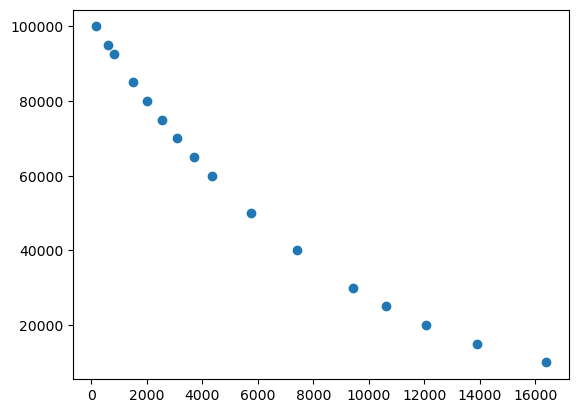

In [13]:
plt.scatter(gph.data,gph.pressure.data)

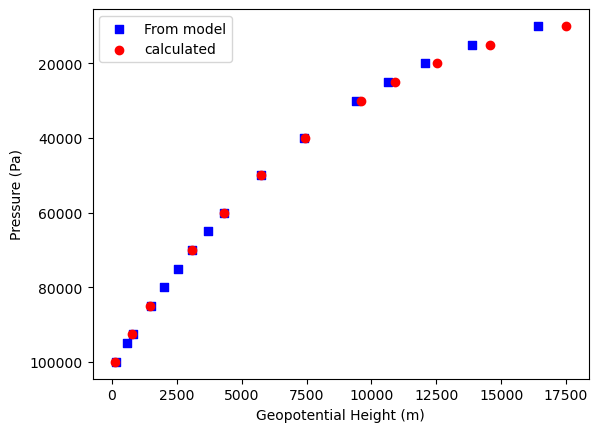

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(111)


ax1.scatter(gph.data, gph.pressure.data, c='b', marker="s", label='From model')
ax1.scatter(ds_tv_pl.sel(lat=-37.81, lon=144.96, method='nearest')[:12],plev19[:12], c='r', marker="o", label='calculated')
plt.legend(loc='upper left')
plt.gca().invert_yaxis()
plt.xlabel("Geopotential Height (m)")
plt.ylabel("Pressure (Pa)")
plt.show()

In [15]:
model_indices=[0,2,3,6,8,9,10,11,12,13,14,15]

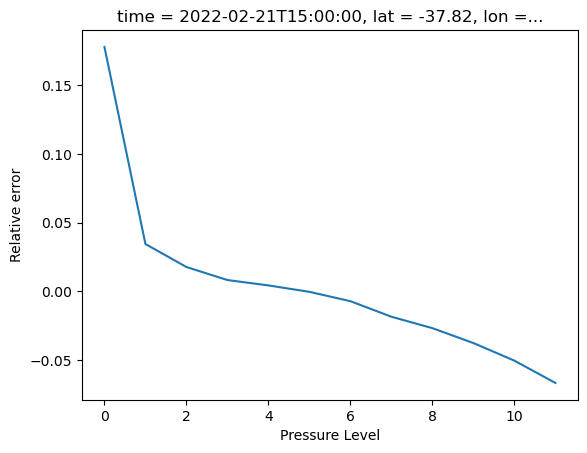

In [16]:
(( gph.data[model_indices] - ds_tv_pl.sel(lat=-37.81, lon=144.96, method='nearest')[:12])/gph.data[model_indices]).plot()
plt.xlabel("Pressure Level")
plt.ylabel("Relative error")
plt.show()